In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [3]:
pip install torch torchvision torchsummary matplotlib numpy pandas scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
import timm  # Library for state-of-the-art vision models

In [5]:
# --- Définition de l'architecture VGG19 ---
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = self._make_layers()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self):
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 
               512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        
        layers = []
        in_channels = 3
        
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        
        return nn.Sequential(*layers)

# --- Définition de l'architecture ResNet34 ---
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# --- Définition de l'architecture DenseNet121 ---
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size):
        super(DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        out = torch.cat([x, out], 1)
        return out

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        x = self.pool(x)
        return x

class DenseNet121(nn.Module):
    def __init__(self, num_classes=1000, growth_rate=32, bn_size=4):
        super(DenseNet121, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        in_channels = 64
        self.block1 = DenseBlock(6, in_channels, growth_rate, bn_size)
        in_channels += 6 * growth_rate
        self.trans1 = TransitionLayer(in_channels, in_channels // 2)
        in_channels = in_channels // 2
        
        self.block2 = DenseBlock(12, in_channels, growth_rate, bn_size)
        in_channels += 12 * growth_rate
        self.trans2 = TransitionLayer(in_channels, in_channels // 2)
        in_channels = in_channels // 2
        
        self.block3 = DenseBlock(24, in_channels, growth_rate, bn_size)
        in_channels += 24 * growth_rate
        self.trans3 = TransitionLayer(in_channels, in_channels // 2)
        in_channels = in_channels // 2
        
        self.block4 = DenseBlock(16, in_channels, growth_rate, bn_size)
        in_channels += 16 * growth_rate
        
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.block3(x)
        x = self.trans3(x)
        x = self.block4(x)
        x = self.relu(self.norm(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# --- Afficher le résumé du modèle ---
def print_model_summary(model, input_size=(3, 224, 224)):
    try:
        device = next(model.parameters()).device
        summary(model, input_size=input_size, device=device.type)
    except Exception as e:
        print("Impossible d'afficher le résumé:", e)

In [6]:
# --- Dataset PlantVillage ---
class PlantVillageDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, train_ratio=0.8):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                images = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
                for img_path in images:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        # Séparation train/val
        total_size = len(self.image_paths)
        indices = np.random.permutation(total_size)
        split_idx = int(total_size * train_ratio)
        
        selected_indices = indices[:split_idx] if train else indices[split_idx:]
        
        self.image_paths = [self.image_paths[i] for i in selected_indices]
        self.labels = [self.labels[i] for i in selected_indices]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# --- Préparation des données ---
def prepare_kaggle_data():
    possible_paths = [
        "/kaggle/input/plantdisease/PlantVillage",
    ]
    
    actual_path = None
    for path in possible_paths:
        if Path(path).exists():
            actual_path = path
            break
    
    if actual_path is None:
        print("Dataset non trouvé. Chemins essayés:")
        for path in possible_paths:
            print(f"  - {path}")
        return None, None, None
    
    print(f"Dataset trouvé à: {actual_path}")
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = PlantVillageDataset(actual_path, transform=train_transform, train=True)
    val_dataset = PlantVillageDataset(actual_path, transform=val_transform, train=False)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    
    # Optimisation des DataLoader
    batch_size = 64
    num_workers = 8
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True, prefetch_factor=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True, prefetch_factor=2)
    
    return train_loader, val_loader, train_dataset.classes

In [7]:
# --- Trainer avec AMP ---
class Trainer:
    def __init__(self, model, train_loader, val_loader, num_classes, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=3, factor=0.5)
        
        # Pour AMP
        self.scaler = torch.cuda.amp.GradScaler()
        
        # Historique
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc="Training")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            
            # AMP : autocast + scaler
            with torch.cuda.amp.autocast():
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
            
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f"{running_loss/(pbar.n+1):.4f}",
                'Acc': f"{100.*correct/total:.2f}%"
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation")
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                with torch.cuda.amp.autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f"{running_loss/(pbar.n+1):.4f}",
                    'Acc': f"{100.*correct/total:.2f}%"
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def train(self, num_epochs=15):
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            
            self.scheduler.step(val_loss)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                }, 'best_model.pth')
                print(f"Meilleur modèle sauvegardé avec précision: {best_acc:.2f}%")
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Best Val Acc: {best_acc:.2f}%")
    
    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()


In [8]:
# --- Évaluation ---
def evaluate_model(model, test_loader, class_names, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluation"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    return accuracy, cm, report

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)
Utilisation de 2 GPU(s) en parallèle


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0828 00:55:20.961000 36 torch/_logging/_internal.py:1089] [0/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Modèle compilé avec torch.compile


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/variables/functions.py:679: UserWarning: Graph break due to unsupported builtin sys._getframe. This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind). If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround. If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use torch.compiler.allow_in_graph.
  torch._dynamo.utils.warn_once(msg)
/tmp/ipykernel_36/452885100.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

Training:   0%|          | 0/258 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipykernel_36/452885100.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_36/452885100.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   2%|▏         | 1/65 [00:03<03:18,  3.11s/it, Los

Meilleur modèle sauvegardé avec précision: 74.71%
Train Loss: 1.0790, Train Acc: 64.52%
Val Loss: 0.7472, Val Acc: 74.71%
Best Val Acc: 74.71%

Epoch 2/15
--------------------------------------------------


Training:   0%|          | 0/258 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipykernel_36/452885100.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 65/65 [00:07<00:00,  8.24it/s, Loss=0.4321, Acc=85.76%]


Meilleur modèle sauvegardé avec précision: 85.76%
Train Loss: 0.5067, Train Acc: 83.00%
Val Loss: 0.4321, Val Acc: 85.76%
Best Val Acc: 85.76%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.41it/s, Loss=0.4351, Acc=85.54%]


Train Loss: 0.3622, Train Acc: 87.98%
Val Loss: 0.4217, Val Acc: 85.54%
Best Val Acc: 85.76%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.24it/s, Loss=0.2393, Acc=91.88%]


Meilleur modèle sauvegardé avec précision: 91.88%
Train Loss: 0.2704, Train Acc: 90.93%
Val Loss: 0.2356, Val Acc: 91.88%
Best Val Acc: 91.88%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.41it/s, Loss=0.3083, Acc=89.61%]


Train Loss: 0.2276, Train Acc: 92.45%
Val Loss: 0.3083, Val Acc: 89.61%
Best Val Acc: 91.88%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.23it/s, Loss=0.1518, Acc=95.08%]


Meilleur modèle sauvegardé avec précision: 95.08%
Train Loss: 0.1985, Train Acc: 93.21%
Val Loss: 0.1495, Val Acc: 95.08%
Best Val Acc: 95.08%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.37it/s, Loss=0.2707, Acc=90.70%]


Train Loss: 0.1766, Train Acc: 94.32%
Val Loss: 0.2624, Val Acc: 90.70%
Best Val Acc: 95.08%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.35it/s, Loss=0.1906, Acc=93.53%]


Train Loss: 0.1445, Train Acc: 95.14%
Val Loss: 0.1906, Val Acc: 93.53%
Best Val Acc: 95.08%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.44it/s, Loss=0.1174, Acc=96.51%]


Meilleur modèle sauvegardé avec précision: 96.51%
Train Loss: 0.1423, Train Acc: 95.43%
Val Loss: 0.1138, Val Acc: 96.51%
Best Val Acc: 96.51%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.32it/s, Loss=0.1354, Acc=95.35%]


Train Loss: 0.1203, Train Acc: 96.03%
Val Loss: 0.1312, Val Acc: 95.35%
Best Val Acc: 96.51%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.37it/s, Loss=0.1204, Acc=95.76%]


Train Loss: 0.1205, Train Acc: 95.95%
Val Loss: 0.1185, Val Acc: 95.76%
Best Val Acc: 96.51%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.38it/s, Loss=0.0673, Acc=97.87%]


Meilleur modèle sauvegardé avec précision: 97.87%
Train Loss: 0.1184, Train Acc: 96.24%
Val Loss: 0.0663, Val Acc: 97.87%
Best Val Acc: 97.87%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.35it/s, Loss=0.1293, Acc=95.88%]


Train Loss: 0.0961, Train Acc: 96.69%
Val Loss: 0.1293, Val Acc: 95.88%
Best Val Acc: 97.87%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.31it/s, Loss=0.0864, Acc=97.24%]


Train Loss: 0.0825, Train Acc: 97.26%
Val Loss: 0.0837, Val Acc: 97.24%
Best Val Acc: 97.87%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:07<00:00,  8.39it/s, Loss=0.1465, Acc=95.59%]


Train Loss: 0.0884, Train Acc: 96.97%
Val Loss: 0.1420, Val Acc: 95.59%
Best Val Acc: 97.87%


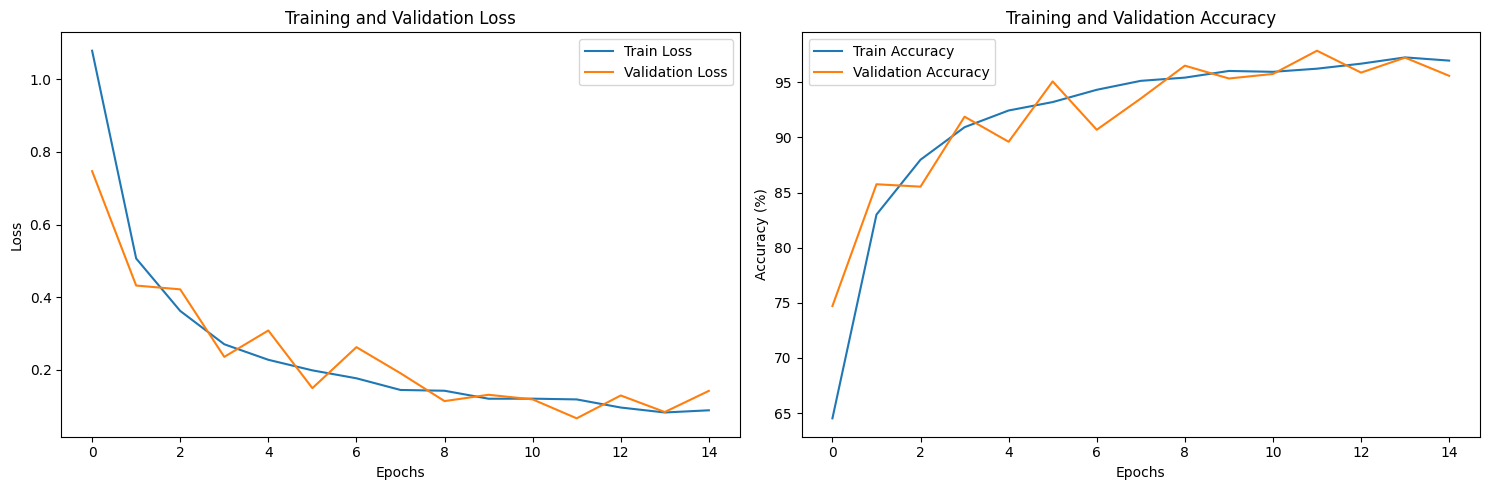


Final Evaluation:


Evaluation:   0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_36/883962962.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 65/65 [00:07<00:00,  8.52it/s]

Accuracy: 0.9559

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.93      0.96       205
                     Pepper__bell___healthy       0.96      1.00      0.98       274
                      Potato___Early_blight       1.00      0.98      0.99       203
                       Potato___Late_blight       0.98      0.97      0.97       204
                           Potato___healthy       0.78      1.00      0.87        31
                      Tomato_Bacterial_spot       0.99      0.98      0.99       449
                        Tomato_Early_blight       0.99      0.75      0.85       222
                         Tomato_Late_blight       0.93      0.96      0.94       366
                           Tomato_Leaf_Mold       0.95      0.94      0.95       179
                  Tomato_Septoria_leaf_spot       0.98      0.88      0.93       359
Tomato_Spider_mites_Two

In [9]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Préparation des données
    train_loader, val_loader, class_names = prepare_kaggle_data()
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'resnet34'  # Changer entre 'vgg19', 'resnet34', 'densenet121'
    
    if model_arch == 'vgg19':
        model = VGG19(num_classes=len(class_names))
    elif model_arch == 'resnet34':
        model = ResNet34(num_classes=len(class_names))
    elif model_arch == 'densenet121':
        model = DenseNet121(num_classes=len(class_names))
    else:
        raise ValueError("Architecture non supportée")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Résumé (facultatif)
    try:
        print_model_summary(model)
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)
Utilisation de 2 GPU(s) en parallèle
Modèle compilé avec torch.compile


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipykernel_36/452885100.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BatchNorm2d-7         [-1, 64, 112, 112]             128
              ReLU-8           [-1, 64, 56, 56]               0
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]           8,192
      BatchNorm2d-14          [-1, 128,

Training:   0%|          | 0/258 [00:00<?, ?it/s]/tmp/ipykernel_36/452885100.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_36/452885100.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 65/65 [00:16<00:00,  3.83it/s, Loss=0.6310, Acc=79.72%]


Meilleur modèle sauvegardé avec précision: 79.72%
Train Loss: 1.1094, Train Acc: 65.78%
Val Loss: 0.6310, Val Acc: 79.72%
Best Val Acc: 79.72%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.76it/s, Loss=0.3928, Acc=87.38%]


Meilleur modèle sauvegardé avec précision: 87.38%
Train Loss: 0.5223, Train Acc: 83.60%
Val Loss: 0.3928, Val Acc: 87.38%
Best Val Acc: 87.38%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.73it/s, Loss=0.2454, Acc=91.81%]


Meilleur modèle sauvegardé avec précision: 91.81%
Train Loss: 0.3556, Train Acc: 88.64%
Val Loss: 0.2454, Val Acc: 91.81%
Best Val Acc: 91.81%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s, Loss=0.1470, Acc=95.25%]


Meilleur modèle sauvegardé avec précision: 95.25%
Train Loss: 0.2812, Train Acc: 91.18%
Val Loss: 0.1470, Val Acc: 95.25%
Best Val Acc: 95.25%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:16<00:00,  3.85it/s, Loss=0.1887, Acc=93.63%]


Train Loss: 0.2225, Train Acc: 93.15%
Val Loss: 0.1887, Val Acc: 93.63%
Best Val Acc: 95.25%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.81it/s, Loss=0.1277, Acc=95.47%]


Meilleur modèle sauvegardé avec précision: 95.47%
Train Loss: 0.1889, Train Acc: 93.91%
Val Loss: 0.1277, Val Acc: 95.47%
Best Val Acc: 95.47%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s, Loss=0.1170, Acc=96.25%]


Meilleur modèle sauvegardé avec précision: 96.25%
Train Loss: 0.1627, Train Acc: 94.85%
Val Loss: 0.1170, Val Acc: 96.25%
Best Val Acc: 96.25%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s, Loss=0.1040, Acc=97.04%]


Meilleur modèle sauvegardé avec précision: 97.04%
Train Loss: 0.1425, Train Acc: 95.32%
Val Loss: 0.1040, Val Acc: 97.04%
Best Val Acc: 97.04%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:16<00:00,  3.85it/s, Loss=0.1222, Acc=95.93%]


Train Loss: 0.1264, Train Acc: 95.94%
Val Loss: 0.1222, Val Acc: 95.93%
Best Val Acc: 97.04%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.72it/s, Loss=0.0684, Acc=97.77%]


Meilleur modèle sauvegardé avec précision: 97.77%
Train Loss: 0.1110, Train Acc: 96.61%
Val Loss: 0.0684, Val Acc: 97.77%
Best Val Acc: 97.77%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.76it/s, Loss=0.0998, Acc=96.90%]


Train Loss: 0.1118, Train Acc: 96.35%
Val Loss: 0.0998, Val Acc: 96.90%
Best Val Acc: 97.77%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s, Loss=0.0593, Acc=98.06%]


Meilleur modèle sauvegardé avec précision: 98.06%
Train Loss: 0.0973, Train Acc: 96.94%
Val Loss: 0.0593, Val Acc: 98.06%
Best Val Acc: 98.06%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.78it/s, Loss=0.0636, Acc=98.09%]


Meilleur modèle sauvegardé avec précision: 98.09%
Train Loss: 0.0895, Train Acc: 97.24%
Val Loss: 0.0636, Val Acc: 98.09%
Best Val Acc: 98.09%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:17<00:00,  3.76it/s, Loss=0.0832, Acc=97.29%]


Train Loss: 0.0835, Train Acc: 97.29%
Val Loss: 0.0832, Val Acc: 97.29%
Best Val Acc: 98.09%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s, Loss=0.0513, Acc=98.45%]


Meilleur modèle sauvegardé avec précision: 98.45%
Train Loss: 0.0801, Train Acc: 97.45%
Val Loss: 0.0513, Val Acc: 98.45%
Best Val Acc: 98.45%


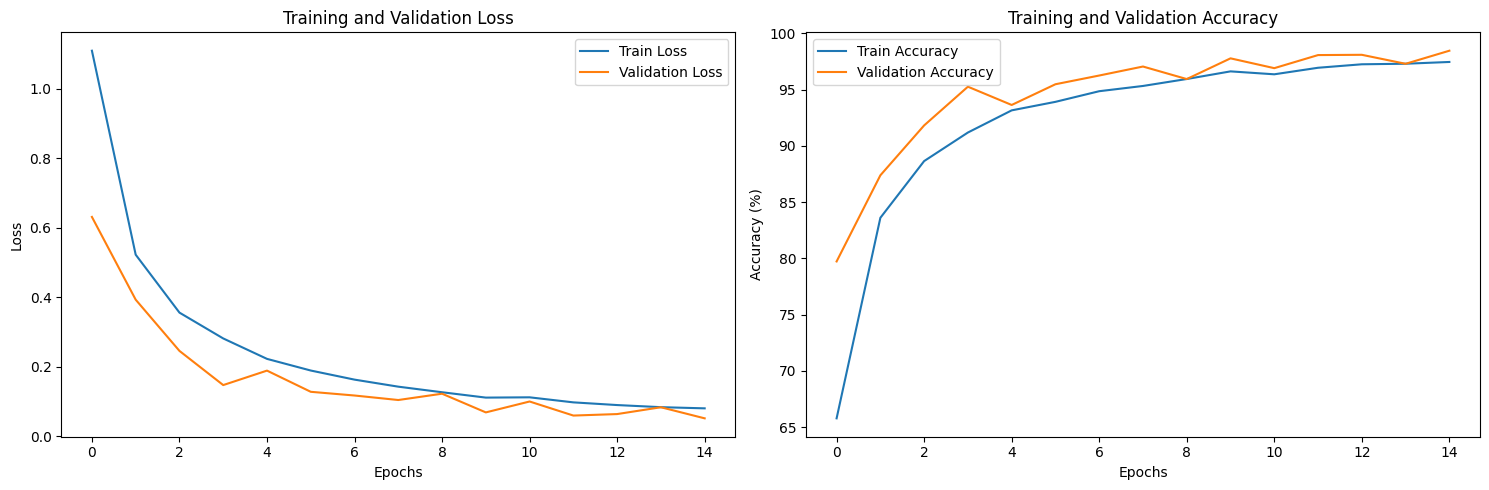


Final Evaluation:


Evaluation:   0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_36/883962962.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]

Accuracy: 0.9845

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.99      1.00       191
                     Pepper__bell___healthy       1.00      0.99      1.00       300
                      Potato___Early_blight       1.00      1.00      1.00       204
                       Potato___Late_blight       1.00      0.99      0.99       220
                           Potato___healthy       1.00      1.00      1.00        30
                      Tomato_Bacterial_spot       0.96      0.98      0.97       426
                        Tomato_Early_blight       0.93      0.93      0.93       198
                         Tomato_Late_blight       0.99      0.97      0.98       364
                           Tomato_Leaf_Mold       1.00      0.98      0.99       172
                  Tomato_Septoria_leaf_spot       0.99      1.00      0.99       346
Tomato_Spider_mites_Two

In [10]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Préparation des données
    train_loader, val_loader, class_names = prepare_kaggle_data()
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'densenet121'  # Changer entre 'vgg19', 'resnet34', 'densenet121'
    
    if model_arch == 'vgg19':
        model = VGG19(num_classes=len(class_names))
    elif model_arch == 'resnet34':
        model = ResNet34(num_classes=len(class_names))
    elif model_arch == 'densenet121':
        model = DenseNet121(num_classes=len(class_names))
    else:
        raise ValueError("Architecture non supportée")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Résumé (facultatif)
    try:
        print_model_summary(model)
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Utilisation de 2 GPU(s) en parallèle
Modèle compilé avec torch.compile


/tmp/ipykernel_36/452885100.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
             ReLU-10         [-1, 64, 224, 224]               0
      BatchNorm2d-11         [-1, 64, 224, 224]             128
        MaxPool2d-12         [-1, 64, 112, 112]               0
             ReLU-13         [-1, 64, 224, 224]               0
        MaxPool2d-14         [-1, 64, 1

Training:   0%|          | 0/258 [00:00<?, ?it/s]/tmp/ipykernel_36/452885100.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_36/452885100.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s, Loss=1.4033, Acc=52.69%]


Meilleur modèle sauvegardé avec précision: 52.69%
Train Loss: 1.9971, Train Acc: 36.41%
Val Loss: 1.4033, Val Acc: 52.69%
Best Val Acc: 52.69%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s, Loss=0.8230, Acc=72.84%]


Meilleur modèle sauvegardé avec précision: 72.84%
Train Loss: 1.1434, Train Acc: 63.27%
Val Loss: 0.8230, Val Acc: 72.84%
Best Val Acc: 72.84%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.26it/s, Loss=0.6608, Acc=78.56%]


Meilleur modèle sauvegardé avec précision: 78.56%
Train Loss: 0.7974, Train Acc: 73.68%
Val Loss: 0.6608, Val Acc: 78.56%
Best Val Acc: 78.56%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.18it/s, Loss=0.4512, Acc=85.08%]


Meilleur modèle sauvegardé avec précision: 85.08%
Train Loss: 0.5930, Train Acc: 80.56%
Val Loss: 0.4512, Val Acc: 85.08%
Best Val Acc: 85.08%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s, Loss=0.3048, Acc=89.53%]


Meilleur modèle sauvegardé avec précision: 89.53%
Train Loss: 0.4739, Train Acc: 84.64%
Val Loss: 0.3048, Val Acc: 89.53%
Best Val Acc: 89.53%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.17it/s, Loss=0.4892, Acc=84.52%]


Train Loss: 0.3869, Train Acc: 87.46%
Val Loss: 0.4892, Val Acc: 84.52%
Best Val Acc: 89.53%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s, Loss=0.3148, Acc=89.05%]


Train Loss: 0.3220, Train Acc: 89.57%
Val Loss: 0.3148, Val Acc: 89.05%
Best Val Acc: 89.53%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.21it/s, Loss=0.2127, Acc=92.85%]


Meilleur modèle sauvegardé avec précision: 92.85%
Train Loss: 0.2888, Train Acc: 90.59%
Val Loss: 0.2127, Val Acc: 92.85%
Best Val Acc: 92.85%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s, Loss=0.1354, Acc=95.28%]


Meilleur modèle sauvegardé avec précision: 95.28%
Train Loss: 0.2519, Train Acc: 91.71%
Val Loss: 0.1354, Val Acc: 95.28%
Best Val Acc: 95.28%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.19it/s, Loss=0.1959, Acc=93.44%]


Train Loss: 0.2384, Train Acc: 92.00%
Val Loss: 0.1959, Val Acc: 93.44%
Best Val Acc: 95.28%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s, Loss=0.1521, Acc=94.94%]


Train Loss: 0.2154, Train Acc: 92.98%
Val Loss: 0.1521, Val Acc: 94.94%
Best Val Acc: 95.28%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s, Loss=0.1037, Acc=96.51%]


Meilleur modèle sauvegardé avec précision: 96.51%
Train Loss: 0.1935, Train Acc: 93.55%
Val Loss: 0.1037, Val Acc: 96.51%
Best Val Acc: 96.51%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.25it/s, Loss=0.1659, Acc=94.06%]


Train Loss: 0.1900, Train Acc: 93.73%
Val Loss: 0.1659, Val Acc: 94.06%
Best Val Acc: 96.51%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s, Loss=0.1486, Acc=95.03%]


Train Loss: 0.1738, Train Acc: 94.31%
Val Loss: 0.1486, Val Acc: 95.03%
Best Val Acc: 96.51%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s, Loss=0.1632, Acc=94.69%]


Train Loss: 0.1792, Train Acc: 94.22%
Val Loss: 0.1632, Val Acc: 94.69%
Best Val Acc: 96.51%


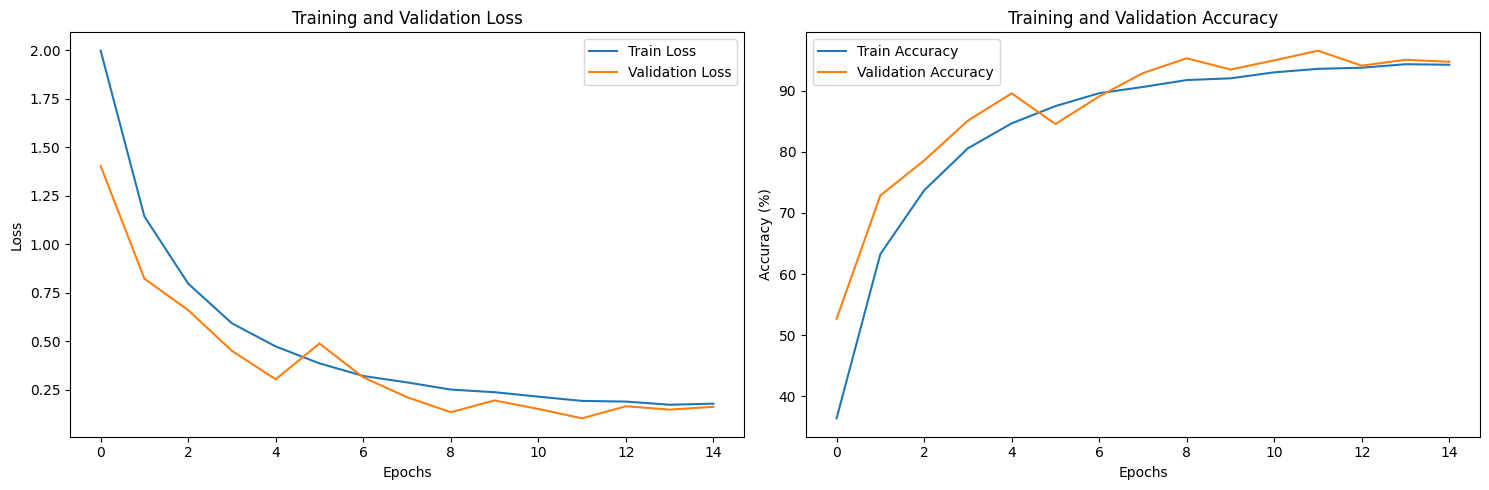


Final Evaluation:


Evaluation:   0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipykernel_36/883962962.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 65/65 [00:12<00:00,  5.27it/s]

Accuracy: 0.9469

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.98      0.96       209
                     Pepper__bell___healthy       1.00      0.99      0.99       293
                      Potato___Early_blight       0.99      0.97      0.98       203
                       Potato___Late_blight       0.99      0.92      0.96       190
                           Potato___healthy       0.93      0.97      0.95        29
                      Tomato_Bacterial_spot       0.96      0.93      0.94       431
                        Tomato_Early_blight       0.97      0.68      0.80       186
                         Tomato_Late_blight       0.86      0.98      0.92       364
                           Tomato_Leaf_Mold       0.85      1.00      0.92       203
                  Tomato_Septoria_leaf_spot       0.99      0.90      0.94       380
Tomato_Spider_mites_Two

In [11]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Préparation des données
    train_loader, val_loader, class_names = prepare_kaggle_data()
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'vgg19'  # Changer entre 'vgg19', 'resnet34', 'densenet121'
    
    if model_arch == 'vgg19':
        model = VGG19(num_classes=len(class_names))
    elif model_arch == 'resnet34':
        model = ResNet34(num_classes=len(class_names))
    elif model_arch == 'densenet121':
        model = DenseNet121(num_classes=len(class_names))
    else:
        raise ValueError("Architecture non supportée")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Résumé (facultatif)
    try:
        print_model_summary(model)
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

In [12]:
# Configuration pour utiliser les modèles pré-entraînés
def create_pretrained_model(model_name, num_classes):
    """
    Crée un modèle pré-entraîné avec une nouvelle tête de classification
    """
    if model_name == 'vgg19':
        model = torchvision.models.vgg19(pretrained=True)
        # Geler les poids du backbone
        for param in model.features.parameters():
            param.requires_grad = False
        # Remplacer le classifieur
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)
        
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
        # Geler les poids du backbone
        for param in model.parameters():
            param.requires_grad = False
        # Remplacer le classifieur
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        
    elif model_name == 'densenet121':
        model = torchvision.models.densenet121(pretrained=True)
        # Geler les poids du backbone
        for param in model.parameters():
            param.requires_grad = False
        # Remplacer le classifieur
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
        
    else:
        raise ValueError(f"Modèle {model_name} non supporté")
    
    return model

# --- Afficher le résumé du modèle ---
def print_model_summary(model, input_size=(3, 224, 224)):
    try:
        # Si le modèle est en DataParallel, on prend le module original
        if isinstance(model, nn.DataParallel):
            model = model.module
            
        # Afficher simplement la structure du modèle
        print(model)
        # Compter le nombre de paramètres
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
    except Exception as e:
        print("Impossible d'afficher le résumé:", e)

In [13]:
# --- Dataset PlantVillage ---
class PlantVillageDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, train_ratio=0.8):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                images = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
                for img_path in images:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        # Séparation train/val
        total_size = len(self.image_paths)
        indices = np.random.permutation(total_size)
        split_idx = int(total_size * train_ratio)
        
        selected_indices = indices[:split_idx] if train else indices[split_idx:]
        
        self.image_paths = [self.image_paths[i] for i in selected_indices]
        self.labels = [self.labels[i] for i in selected_indices]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# --- Préparation des données ---
def prepare_kaggle_data():
    possible_paths = [
        "/kaggle/input/plantdisease/PlantVillage",
    ]
    
    actual_path = None
    for path in possible_paths:
        if Path(path).exists():
            actual_path = path
            break
    
    if actual_path is None:
        print("Dataset non trouvé. Chemins essayés:")
        for path in possible_paths:
            print(f"  - {path}")
        return None, None, None
    
    print(f"Dataset trouvé à: {actual_path}")
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = PlantVillageDataset(actual_path, transform=train_transform, train=True)
    val_dataset = PlantVillageDataset(actual_path, transform=val_transform, train=False)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    
    # Optimisation des DataLoader
    batch_size = 32  # Réduit pour éviter les problèmes de mémoire
    num_workers = 2  # Réduit pour éviter les problèmes
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, train_dataset.classes

In [14]:
# --- Trainer avec AMP ---
class Trainer:
    def __init__(self, model, train_loader, val_loader, num_classes, device='cuda', freeze_backbone=True):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        
        # Différencier les paramètres à entraîner selon qu'on freeze le backbone ou non
        if freeze_backbone:
            # N'entraîner que les paramètres qui nécessitent des gradients
            trainable_params = [p for p in model.parameters() if p.requires_grad]  # Convertir en liste
            print(f"Nombre de paramètres entraînables: {sum(p.numel() for p in trainable_params):,}")
            
            # Vérifier qu'il y a des paramètres à entraîner
            if len(trainable_params) == 0:
                print("Avertissement: Aucun paramètre à entraîner. Déblocage de certaines couches.")
                # Débloquer les dernières couches du modèle
                self._unfreeze_last_layers(model)
                trainable_params = [p for p in model.parameters() if p.requires_grad]
                
            self.optimizer = optim.Adam(trainable_params, lr=0.0001, weight_decay=1e-4)
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
            
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=3, factor=0.5)
        
        # Pour AMP - Correction de l'initialisation de GradScaler
        if device.type == 'cuda':
            self.scaler = torch.cuda.amp.GradScaler()
        else:
            self.scaler = None
        
        # Historique
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def _unfreeze_last_layers(self, model):
        """Débloquer les dernières couches si tout est gelé"""
        # Si le modèle est en DataParallel, on travaille avec le module original
        if isinstance(model, nn.DataParallel):
            model = model.module
            
        # Débloquer les dernières couches selon l'architecture
        if hasattr(model, 'classifier'):
            # Pour VGG et DenseNet
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif hasattr(model, 'fc'):
            # Pour ResNet
            for param in model.fc.parameters():
                param.requires_grad = True
        elif hasattr(model, 'features'):
            # Débloquer les dernières couches de features
            for param in model.features[-2:].parameters():  # Dernières couches
                param.requires_grad = True
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc="Training")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            
            # AMP : autocast + scaler
            if self.device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f"{running_loss/(pbar.n+1):.4f}",
                'Acc': f"{100.*correct/total:.2f}%"
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation")
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                if self.device.type == 'cuda':
                    with torch.cuda.amp.autocast():
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)
                else:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f"{running_loss/(pbar.n+1):.4f}",
                    'Acc': f"{100.*correct/total:.2f}%"
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def train(self, num_epochs=15):
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            
            self.scheduler.step(val_loss)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                }, 'best_model.pth')
                print(f"Meilleur modèle sauvegardé avec précision: {best_acc:.2f}%")
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Best Val Acc: {best_acc:.2f}%")
    
    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

In [15]:
# --- Évaluation ---
def evaluate_model(model, test_loader, class_names, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluation"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
            else:
                outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    return accuracy, cm, report

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 168MB/s]
/tmp/ipykernel_36/835392874.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = to

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Training:   0%|          | 0/516 [00:00<?, ?it/s]/tmp/ipykernel_36/835392874.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/835392874.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 129/129 [00:28<00:00,  4.56it/s, Loss=1.5029, Acc=72.02%]


Meilleur modèle sauvegardé avec précision: 72.02%
Train Loss: 2.0038, Train Acc: 45.39%
Val Loss: 1.5029, Val Acc: 72.02%
Best Val Acc: 72.02%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.53it/s, Loss=1.0313, Acc=80.47%]


Meilleur modèle sauvegardé avec précision: 80.47%
Train Loss: 1.2619, Train Acc: 73.77%
Val Loss: 1.0313, Val Acc: 80.47%
Best Val Acc: 80.47%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.55it/s, Loss=0.7814, Acc=85.61%]


Meilleur modèle sauvegardé avec précision: 85.61%
Train Loss: 0.9486, Train Acc: 79.97%
Val Loss: 0.7814, Val Acc: 85.61%
Best Val Acc: 85.61%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.55it/s, Loss=0.6444, Acc=87.45%]


Meilleur modèle sauvegardé avec précision: 87.45%
Train Loss: 0.7698, Train Acc: 83.33%
Val Loss: 0.6444, Val Acc: 87.45%
Best Val Acc: 87.45%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.55it/s, Loss=0.5449, Acc=89.07%]


Meilleur modèle sauvegardé avec précision: 89.07%
Train Loss: 0.6687, Train Acc: 85.15%
Val Loss: 0.5449, Val Acc: 89.07%
Best Val Acc: 89.07%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.57it/s, Loss=0.4757, Acc=90.53%]


Meilleur modèle sauvegardé avec précision: 90.53%
Train Loss: 0.5824, Train Acc: 86.75%
Val Loss: 0.4757, Val Acc: 90.53%
Best Val Acc: 90.53%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.53it/s, Loss=0.4368, Acc=90.92%]


Meilleur modèle sauvegardé avec précision: 90.92%
Train Loss: 0.5376, Train Acc: 87.38%
Val Loss: 0.4368, Val Acc: 90.92%
Best Val Acc: 90.92%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.50it/s, Loss=0.3955, Acc=91.38%]


Meilleur modèle sauvegardé avec précision: 91.38%
Train Loss: 0.4921, Train Acc: 87.97%
Val Loss: 0.3955, Val Acc: 91.38%
Best Val Acc: 91.38%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.59it/s, Loss=0.3587, Acc=91.98%]


Meilleur modèle sauvegardé avec précision: 91.98%
Train Loss: 0.4610, Train Acc: 88.64%
Val Loss: 0.3587, Val Acc: 91.98%
Best Val Acc: 91.98%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.54it/s, Loss=0.3388, Acc=92.81%]


Meilleur modèle sauvegardé avec précision: 92.81%
Train Loss: 0.4279, Train Acc: 89.55%
Val Loss: 0.3388, Val Acc: 92.81%
Best Val Acc: 92.81%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.58it/s, Loss=0.3193, Acc=93.00%]


Meilleur modèle sauvegardé avec précision: 93.00%
Train Loss: 0.4099, Train Acc: 89.84%
Val Loss: 0.3193, Val Acc: 93.00%
Best Val Acc: 93.00%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.51it/s, Loss=0.3033, Acc=93.07%]


Meilleur modèle sauvegardé avec précision: 93.07%
Train Loss: 0.3841, Train Acc: 89.92%
Val Loss: 0.3033, Val Acc: 93.07%
Best Val Acc: 93.07%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.54it/s, Loss=0.2855, Acc=93.51%]


Meilleur modèle sauvegardé avec précision: 93.51%
Train Loss: 0.3727, Train Acc: 90.02%
Val Loss: 0.2855, Val Acc: 93.51%
Best Val Acc: 93.51%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.55it/s, Loss=0.2690, Acc=93.99%]


Meilleur modèle sauvegardé avec précision: 93.99%
Train Loss: 0.3557, Train Acc: 90.90%
Val Loss: 0.2690, Val Acc: 93.99%
Best Val Acc: 93.99%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:28<00:00,  4.60it/s, Loss=0.2626, Acc=94.04%]


Meilleur modèle sauvegardé avec précision: 94.04%
Train Loss: 0.3450, Train Acc: 90.81%
Val Loss: 0.2626, Val Acc: 94.04%
Best Val Acc: 94.04%


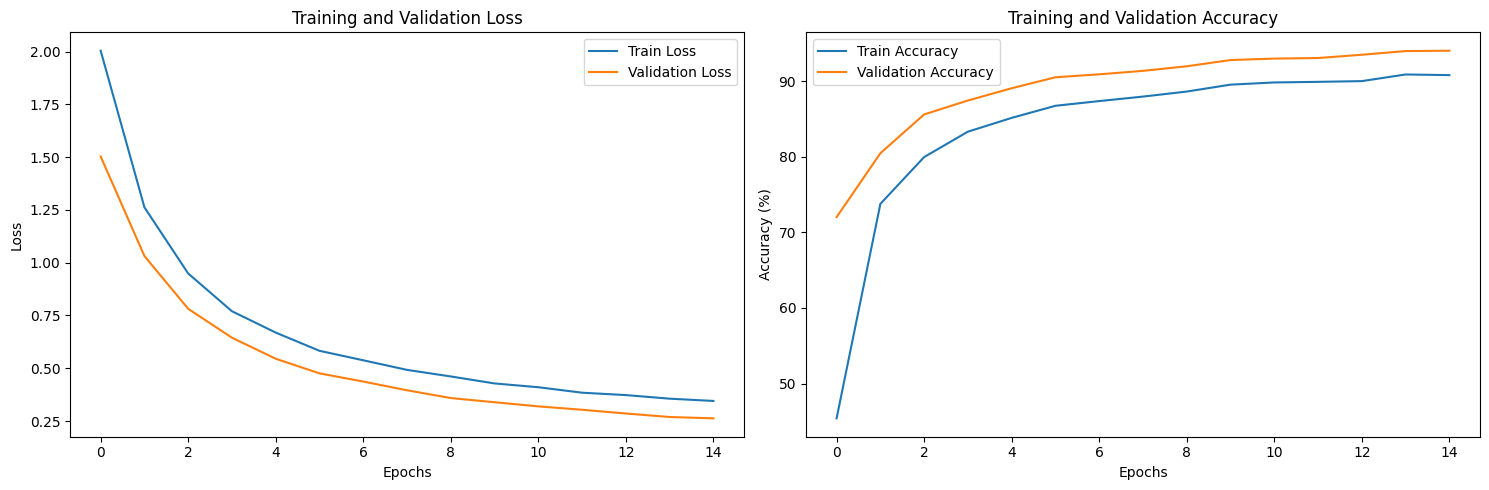


Final Evaluation:


Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/1021250105.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 129/129 [00:28<00:00,  4.52it/s]

Accuracy: 0.9404

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.96      0.97       204
                     Pepper__bell___healthy       0.99      0.99      0.99       287
                      Potato___Early_blight       0.97      0.96      0.96       171
                       Potato___Late_blight       0.96      0.94      0.95       211
                           Potato___healthy       1.00      0.96      0.98        27
                      Tomato_Bacterial_spot       0.93      0.97      0.95       433
                        Tomato_Early_blight       0.85      0.83      0.84       224
                         Tomato_Late_blight       0.92      0.90      0.91       365
                           Tomato_Leaf_Mold       0.91      0.93      0.92       191
                  Tomato_Septoria_leaf_spot       0.91      0.92      0.92       354
Tomato_Spider_mites_Two

In [16]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Préparation des données
    train_loader, val_loader, class_names = prepare_kaggle_data()
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'densenet121'  # Changer entre 'vgg19', 'resnet34', 'densenet121'
    freeze_backbone = True  # Geler les poids pré-entraînés
    
    # Création du modèle pré-entraîné
    model = create_pretrained_model(model_arch, len(class_names))
    
    # Résumé avant la parallélisation
    try:
        print_model_summary(model.to(device))
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device, freeze_backbone=freeze_backbone)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s] 
/tmp/ipykernel_36/835392874.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.am

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training:   0%|          | 0/516 [00:00<?, ?it/s]/tmp/ipykernel_36/835392874.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/835392874.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 129/129 [00:10<00:00, 12.07it/s, Loss=1.6361, Acc=62.38%]


Meilleur modèle sauvegardé avec précision: 62.38%
Train Loss: 2.0883, Train Acc: 39.65%
Val Loss: 1.6234, Val Acc: 62.38%
Best Val Acc: 62.38%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.57it/s, Loss=1.1692, Acc=75.82%]


Meilleur modèle sauvegardé avec précision: 75.82%
Train Loss: 1.3966, Train Acc: 68.03%
Val Loss: 1.1601, Val Acc: 75.82%
Best Val Acc: 75.82%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 11.89it/s, Loss=0.9468, Acc=79.46%]


Meilleur modèle sauvegardé avec précision: 79.46%
Train Loss: 1.0815, Train Acc: 75.03%
Val Loss: 0.9394, Val Acc: 79.46%
Best Val Acc: 79.46%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.31it/s, Loss=0.8047, Acc=82.24%]


Meilleur modèle sauvegardé avec précision: 82.24%
Train Loss: 0.9104, Train Acc: 78.23%
Val Loss: 0.7984, Val Acc: 82.24%
Best Val Acc: 82.24%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:11<00:00, 11.61it/s, Loss=0.7156, Acc=83.50%]


Meilleur modèle sauvegardé avec précision: 83.50%
Train Loss: 0.8025, Train Acc: 79.79%
Val Loss: 0.7101, Val Acc: 83.50%
Best Val Acc: 83.50%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.20it/s, Loss=0.6407, Acc=85.15%]


Meilleur modèle sauvegardé avec précision: 85.15%
Train Loss: 0.7311, Train Acc: 81.38%
Val Loss: 0.6357, Val Acc: 85.15%
Best Val Acc: 85.15%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:11<00:00, 11.66it/s, Loss=0.5955, Acc=85.37%]


Meilleur modèle sauvegardé avec précision: 85.37%
Train Loss: 0.6726, Train Acc: 82.63%
Val Loss: 0.5909, Val Acc: 85.37%
Best Val Acc: 85.37%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.07it/s, Loss=0.5497, Acc=86.22%]


Meilleur modèle sauvegardé avec précision: 86.22%
Train Loss: 0.6289, Train Acc: 83.21%
Val Loss: 0.5455, Val Acc: 86.22%
Best Val Acc: 86.22%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.04it/s, Loss=0.5229, Acc=86.65%]


Meilleur modèle sauvegardé avec précision: 86.65%
Train Loss: 0.5899, Train Acc: 83.99%
Val Loss: 0.5189, Val Acc: 86.65%
Best Val Acc: 86.65%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:11<00:00, 11.60it/s, Loss=0.4933, Acc=86.99%]


Meilleur modèle sauvegardé avec précision: 86.99%
Train Loss: 0.5680, Train Acc: 84.35%
Val Loss: 0.4894, Val Acc: 86.99%
Best Val Acc: 86.99%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.52it/s, Loss=0.4697, Acc=87.35%]


Meilleur modèle sauvegardé avec précision: 87.35%
Train Loss: 0.5421, Train Acc: 85.18%
Val Loss: 0.4661, Val Acc: 87.35%
Best Val Acc: 87.35%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.14it/s, Loss=0.4496, Acc=88.37%]


Meilleur modèle sauvegardé avec précision: 88.37%
Train Loss: 0.5167, Train Acc: 85.69%
Val Loss: 0.4461, Val Acc: 88.37%
Best Val Acc: 88.37%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.46it/s, Loss=0.4298, Acc=87.98%]


Train Loss: 0.5042, Train Acc: 85.44%
Val Loss: 0.4265, Val Acc: 87.98%
Best Val Acc: 88.37%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.41it/s, Loss=0.4262, Acc=88.15%]


Train Loss: 0.4915, Train Acc: 85.98%
Val Loss: 0.4229, Val Acc: 88.15%
Best Val Acc: 88.37%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.29it/s, Loss=0.4111, Acc=88.42%]


Meilleur modèle sauvegardé avec précision: 88.42%
Train Loss: 0.4821, Train Acc: 86.13%
Val Loss: 0.4079, Val Acc: 88.42%
Best Val Acc: 88.42%


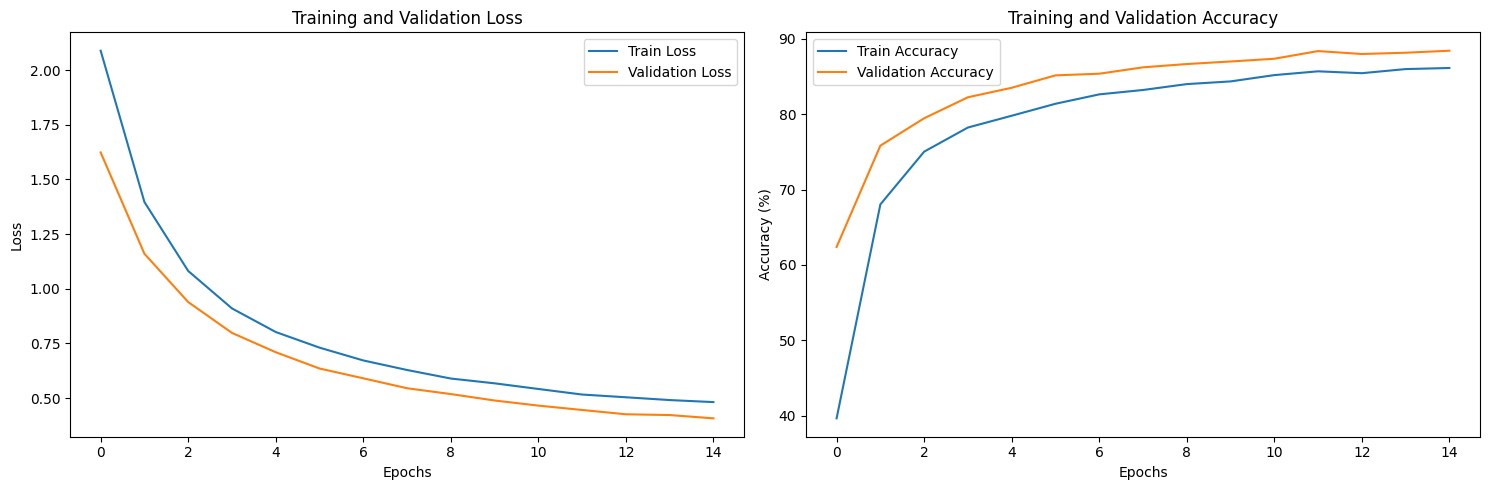


Final Evaluation:


Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/1021250105.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 129/129 [00:10<00:00, 12.13it/s]

Accuracy: 0.8842

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.91      0.95       211
                     Pepper__bell___healthy       0.94      1.00      0.97       307
                      Potato___Early_blight       0.94      0.94      0.94       202
                       Potato___Late_blight       0.84      0.95      0.89       224
                           Potato___healthy       0.97      0.91      0.94        32
                      Tomato_Bacterial_spot       0.87      0.93      0.90       439
                        Tomato_Early_blight       0.82      0.60      0.70       184
                         Tomato_Late_blight       0.84      0.87      0.85       393
                           Tomato_Leaf_Mold       0.82      0.73      0.77       193
                  Tomato_Septoria_leaf_spot       0.82      0.81      0.82       339
Tomato_Spider_mites_Two

In [17]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Préparation des données
    train_loader, val_loader, class_names = prepare_kaggle_data()
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'resnet34'  # Changer entre 'vgg19', 'resnet34', 'densenet121'
    freeze_backbone = True  # Geler les poids pré-entraînés
    
    # Création du modèle pré-entraîné
    model = create_pretrained_model(model_arch, len(class_names))
    
    # Résumé avant la parallélisation
    try:
        print_model_summary(model.to(device))
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device, freeze_backbone=freeze_backbone)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 211MB/s]  
/tmp/ipykernel_36/835392874.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Training:   0%|          | 0/516 [00:00<?, ?it/s]/tmp/ipykernel_36/835392874.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/835392874.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 129/129 [00:13<00:00,  9.43it/s, Loss=0.2627, Acc=91.21%]


Meilleur modèle sauvegardé avec précision: 91.21%
Train Loss: 0.7123, Train Acc: 76.62%
Val Loss: 0.2627, Val Acc: 91.21%
Best Val Acc: 91.21%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.40it/s, Loss=0.2123, Acc=92.76%]


Meilleur modèle sauvegardé avec précision: 92.76%
Train Loss: 0.3622, Train Acc: 87.90%
Val Loss: 0.2123, Val Acc: 92.76%
Best Val Acc: 92.76%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.42it/s, Loss=0.1388, Acc=95.30%]


Meilleur modèle sauvegardé avec précision: 95.30%
Train Loss: 0.2889, Train Acc: 90.24%
Val Loss: 0.1388, Val Acc: 95.30%
Best Val Acc: 95.30%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.44it/s, Loss=0.1196, Acc=96.08%]


Meilleur modèle sauvegardé avec précision: 96.08%
Train Loss: 0.2447, Train Acc: 91.95%
Val Loss: 0.1196, Val Acc: 96.08%
Best Val Acc: 96.08%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.41it/s, Loss=0.1140, Acc=96.08%]


Train Loss: 0.2199, Train Acc: 92.36%
Val Loss: 0.1140, Val Acc: 96.08%
Best Val Acc: 96.08%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.44it/s, Loss=0.1098, Acc=96.37%]


Meilleur modèle sauvegardé avec précision: 96.37%
Train Loss: 0.1968, Train Acc: 93.17%
Val Loss: 0.1098, Val Acc: 96.37%
Best Val Acc: 96.37%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.45it/s, Loss=0.0956, Acc=96.66%]


Meilleur modèle sauvegardé avec précision: 96.66%
Train Loss: 0.1724, Train Acc: 94.19%
Val Loss: 0.0956, Val Acc: 96.66%
Best Val Acc: 96.66%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.45it/s, Loss=0.0765, Acc=97.43%]


Meilleur modèle sauvegardé avec précision: 97.43%
Train Loss: 0.1752, Train Acc: 93.89%
Val Loss: 0.0765, Val Acc: 97.43%
Best Val Acc: 97.43%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.46it/s, Loss=0.0742, Acc=97.34%]


Train Loss: 0.1695, Train Acc: 94.29%
Val Loss: 0.0742, Val Acc: 97.34%
Best Val Acc: 97.43%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.45it/s, Loss=0.0724, Acc=97.36%]


Train Loss: 0.1401, Train Acc: 95.28%
Val Loss: 0.0724, Val Acc: 97.36%
Best Val Acc: 97.43%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.43it/s, Loss=0.0603, Acc=97.84%]


Meilleur modèle sauvegardé avec précision: 97.84%
Train Loss: 0.1581, Train Acc: 94.77%
Val Loss: 0.0603, Val Acc: 97.84%
Best Val Acc: 97.84%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.44it/s, Loss=0.0695, Acc=97.63%]


Train Loss: 0.1276, Train Acc: 95.54%
Val Loss: 0.0695, Val Acc: 97.63%
Best Val Acc: 97.84%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.45it/s, Loss=0.0547, Acc=98.16%]


Meilleur modèle sauvegardé avec précision: 98.16%
Train Loss: 0.1268, Train Acc: 95.63%
Val Loss: 0.0547, Val Acc: 98.16%
Best Val Acc: 98.16%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:13<00:00,  9.46it/s, Loss=0.0517, Acc=98.18%]


Meilleur modèle sauvegardé avec précision: 98.18%
Train Loss: 0.1268, Train Acc: 95.63%
Val Loss: 0.0517, Val Acc: 98.18%
Best Val Acc: 98.18%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:14<00:00,  9.16it/s, Loss=0.0571, Acc=98.04%]


Train Loss: 0.1255, Train Acc: 95.74%
Val Loss: 0.0571, Val Acc: 98.04%
Best Val Acc: 98.18%


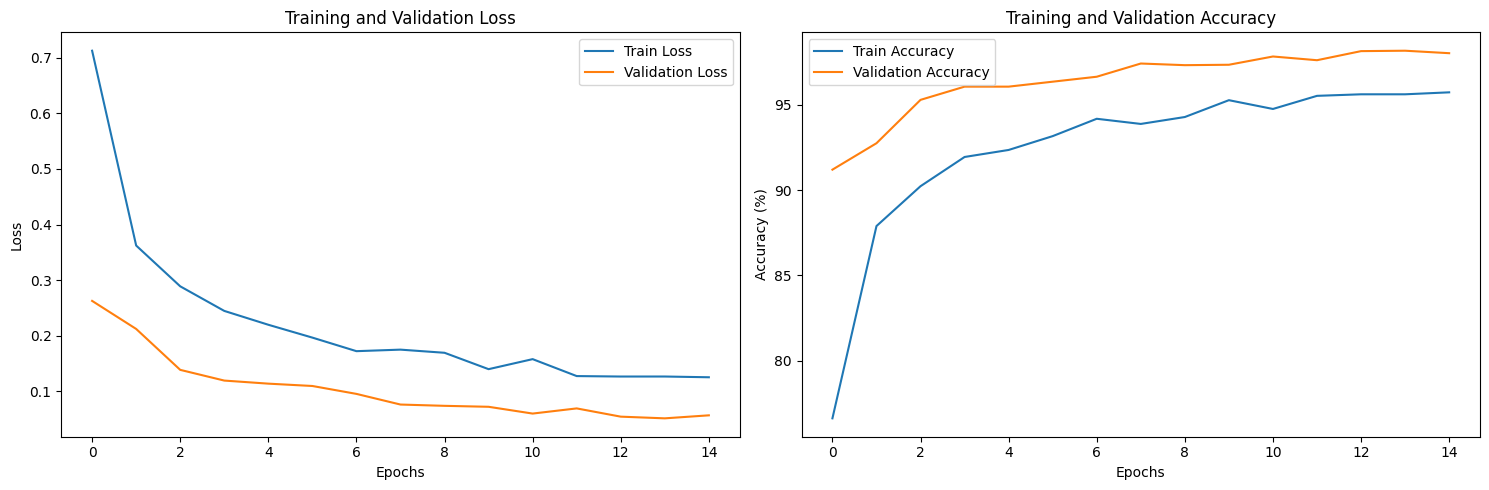


Final Evaluation:


Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/1021250105.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 129/129 [00:13<00:00,  9.57it/s]

Accuracy: 0.9804

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      1.00      0.99       215
                     Pepper__bell___healthy       1.00      1.00      1.00       306
                      Potato___Early_blight       0.98      1.00      0.99       210
                       Potato___Late_blight       0.99      0.98      0.99       184
                           Potato___healthy       1.00      0.96      0.98        24
                      Tomato_Bacterial_spot       0.98      0.99      0.99       424
                        Tomato_Early_blight       0.86      0.99      0.92       181
                         Tomato_Late_blight       1.00      0.96      0.98       363
                           Tomato_Leaf_Mold       0.96      0.99      0.97       213
                  Tomato_Septoria_leaf_spot       0.98      0.96      0.97       359
Tomato_Spider_mites_Two

In [18]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Préparation des données
    train_loader, val_loader, class_names = prepare_kaggle_data()
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'vgg19'  # Changer entre 'vgg19', 'resnet34', 'densenet121'
    freeze_backbone = True  # Geler les poids pré-entraînés
    
    # Création du modèle pré-entraîné
    model = create_pretrained_model(model_arch, len(class_names))
    
    # Résumé avant la parallélisation
    try:
        print_model_summary(model.to(device))
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device, freeze_backbone=freeze_backbone)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

In [19]:
# Configuration pour utiliser les modèles pré-entraînés
def create_pretrained_model(model_name, num_classes):
    """
    Crée un modèle pré-entraîné avec une nouvelle tête de classification
    """
    if model_name == 'efficientnet_b0':
        # Utilisation de timm pour EfficientNet
        model = timm.create_model('efficientnet_b0', pretrained=True)
        # Geler les poids du backbone
        for param in model.parameters():
            param.requires_grad = False
        # Remplacer le classifieur
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
        
    elif model_name == 'vit_base_patch16_224':
        # Utilisation de timm pour Vision Transformer
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Geler les poids du backbone
        for param in model.parameters():
            param.requires_grad = False
        # Remplacer le classifieur
        num_features = model.head.in_features
        model.head = nn.Linear(num_features, num_classes)
        
    else:
        raise ValueError(f"Modèle {model_name} non supporté. Choisissez 'efficientnet_b0' ou 'vit_base_patch16_224'")
    
    return model

# --- Afficher le résumé du modèle ---
def print_model_summary(model):
    try:
        # Si le modèle est en DataParallel, on prend le module original
        if isinstance(model, nn.DataParallel):
            model = model.module
            
        # Afficher simplement la structure du modèle
        print(model)
        # Compter le nombre de paramètres
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
    except Exception as e:
        print("Impossible d'afficher le résumé:", e)

In [20]:
# --- Dataset PlantVillage ---
class PlantVillageDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, train_ratio=0.8):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                images = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
                for img_path in images:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        # Séparation train/val
        total_size = len(self.image_paths)
        indices = np.random.permutation(total_size)
        split_idx = int(total_size * train_ratio)
        
        selected_indices = indices[:split_idx] if train else indices[split_idx:]
        
        self.image_paths = [self.image_paths[i] for i in selected_indices]
        self.labels = [self.labels[i] for i in selected_indices]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# --- Préparation des données ---
def prepare_data(data_path):
    actual_path = Path(data_path)
    
    if not actual_path.exists():
        print(f"Dataset non trouvé à: {data_path}")
        return None, None, None
    
    print(f"Dataset trouvé à: {actual_path}")
    
    # Transformations pour EfficientNet et ViT (même taille d'entrée)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = PlantVillageDataset(actual_path, transform=train_transform, train=True)
    val_dataset = PlantVillageDataset(actual_path, transform=val_transform, train=False)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    
    # Optimisation des DataLoader
    batch_size = 32
    num_workers = 2
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, train_dataset.classes

In [21]:
# --- Trainer avec AMP ---
class Trainer:
    def __init__(self, model, train_loader, val_loader, num_classes, device='cuda', freeze_backbone=True):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        
        # Différencier les paramètres à entraîner selon qu'on freeze le backbone ou non
        if freeze_backbone:
            # N'entraîner que les paramètres qui nécessitent des gradients
            trainable_params = [p for p in model.parameters() if p.requires_grad]
            print(f"Nombre de paramètres entraînables: {sum(p.numel() for p in trainable_params):,}")
            
            # Vérifier qu'il y a des paramètres à entraîner
            if len(trainable_params) == 0:
                print("Avertissement: Aucun paramètre à entraîner. Déblocage de certaines couches.")
                # Débloquer les dernières couches du modèle
                self._unfreeze_last_layers(model)
                trainable_params = [p for p in model.parameters() if p.requires_grad]
                
            self.optimizer = optim.Adam(trainable_params, lr=0.0001, weight_decay=1e-4)
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
            
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=3, factor=0.5)
        
        # Pour AMP
        if device.type == 'cuda':
            self.scaler = torch.cuda.amp.GradScaler()
        else:
            self.scaler = None
        
        # Historique
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def _unfreeze_last_layers(self, model):
        """Débloquer les dernières couches si tout est gelé"""
        # Si le modèle est en DataParallel, on travaille avec le module original
        if isinstance(model, nn.DataParallel):
            model = model.module
            
        # Débloquer les dernières couches selon l'architecture
        if hasattr(model, 'classifier'):
            # Pour EfficientNet
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif hasattr(model, 'head'):
            # Pour ViT
            for param in model.head.parameters():
                param.requires_grad = True
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc="Training")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            
            # AMP : autocast + scaler
            if self.device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f"{running_loss/(pbar.n+1):.4f}",
                'Acc': f"{100.*correct/total:.2f}%"
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation")
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                if self.device.type == 'cuda':
                    with torch.cuda.amp.autocast():
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)
                else:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f"{running_loss/(pbar.n+1):.4f}",
                    'Acc': f"{100.*correct/total:.2f}%"
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def train(self, num_epochs=15):
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            
            self.scheduler.step(val_loss)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                }, 'best_model.pth')
                print(f"Meilleur modèle sauvegardé avec précision: {best_acc:.2f}%")
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Best Val Acc: {best_acc:.2f}%")
    
    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

In [22]:
# --- Évaluation ---
def evaluate_model(model, test_loader, class_names, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluation"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
            else:
                outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    return accuracy, cm, report

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipykernel_36/434000615.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

Training:   0%|          | 0/516 [00:00<?, ?it/s]/tmp/ipykernel_36/434000615.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/434000615.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 129/129 [00:17<00:00,  7.57it/s, Loss=1.3212, Acc=76.26%]


Meilleur modèle sauvegardé avec précision: 76.26%
Train Loss: 1.8628, Train Acc: 58.96%
Val Loss: 1.3212, Val Acc: 76.26%
Best Val Acc: 76.26%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.52it/s, Loss=0.9106, Acc=81.32%]


Meilleur modèle sauvegardé avec précision: 81.32%
Train Loss: 1.1053, Train Acc: 77.50%
Val Loss: 0.9106, Val Acc: 81.32%
Best Val Acc: 81.32%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.53it/s, Loss=0.7291, Acc=84.23%]


Meilleur modèle sauvegardé avec précision: 84.23%
Train Loss: 0.8269, Train Acc: 81.79%
Val Loss: 0.7235, Val Acc: 84.23%
Best Val Acc: 84.23%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.32it/s, Loss=0.6234, Acc=86.34%]


Meilleur modèle sauvegardé avec précision: 86.34%
Train Loss: 0.6936, Train Acc: 83.74%
Val Loss: 0.6234, Val Acc: 86.34%
Best Val Acc: 86.34%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.34it/s, Loss=0.5498, Acc=87.45%]


Meilleur modèle sauvegardé avec précision: 87.45%
Train Loss: 0.6021, Train Acc: 85.58%
Val Loss: 0.5455, Val Acc: 87.45%
Best Val Acc: 87.45%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.34it/s, Loss=0.4838, Acc=88.95%]


Meilleur modèle sauvegardé avec précision: 88.95%
Train Loss: 0.5350, Train Acc: 86.90%
Val Loss: 0.4801, Val Acc: 88.95%
Best Val Acc: 88.95%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.52it/s, Loss=0.4493, Acc=89.39%]


Meilleur modèle sauvegardé avec précision: 89.39%
Train Loss: 0.4933, Train Acc: 87.38%
Val Loss: 0.4493, Val Acc: 89.39%
Best Val Acc: 89.39%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.30it/s, Loss=0.4055, Acc=90.16%]


Meilleur modèle sauvegardé avec précision: 90.16%
Train Loss: 0.4632, Train Acc: 88.18%
Val Loss: 0.4055, Val Acc: 90.16%
Best Val Acc: 90.16%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.32it/s, Loss=0.3993, Acc=89.92%]


Train Loss: 0.4397, Train Acc: 88.33%
Val Loss: 0.3963, Val Acc: 89.92%
Best Val Acc: 90.16%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.40it/s, Loss=0.3650, Acc=90.79%]


Meilleur modèle sauvegardé avec précision: 90.79%
Train Loss: 0.4128, Train Acc: 89.16%
Val Loss: 0.3650, Val Acc: 90.79%
Best Val Acc: 90.79%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.33it/s, Loss=0.3559, Acc=90.99%]


Meilleur modèle sauvegardé avec précision: 90.99%
Train Loss: 0.3992, Train Acc: 89.04%
Val Loss: 0.3531, Val Acc: 90.99%
Best Val Acc: 90.99%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, Loss=0.3411, Acc=91.33%]


Meilleur modèle sauvegardé avec précision: 91.33%
Train Loss: 0.3767, Train Acc: 89.88%
Val Loss: 0.3385, Val Acc: 91.33%
Best Val Acc: 91.33%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.32it/s, Loss=0.3291, Acc=91.69%]


Meilleur modèle sauvegardé avec précision: 91.69%
Train Loss: 0.3686, Train Acc: 89.98%
Val Loss: 0.3266, Val Acc: 91.69%
Best Val Acc: 91.69%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.49it/s, Loss=0.3219, Acc=91.57%]


Train Loss: 0.3508, Train Acc: 90.35%
Val Loss: 0.3219, Val Acc: 91.57%
Best Val Acc: 91.69%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:17<00:00,  7.34it/s, Loss=0.2987, Acc=91.88%]


Meilleur modèle sauvegardé avec précision: 91.88%
Train Loss: 0.3453, Train Acc: 90.33%
Val Loss: 0.2963, Val Acc: 91.88%
Best Val Acc: 91.88%


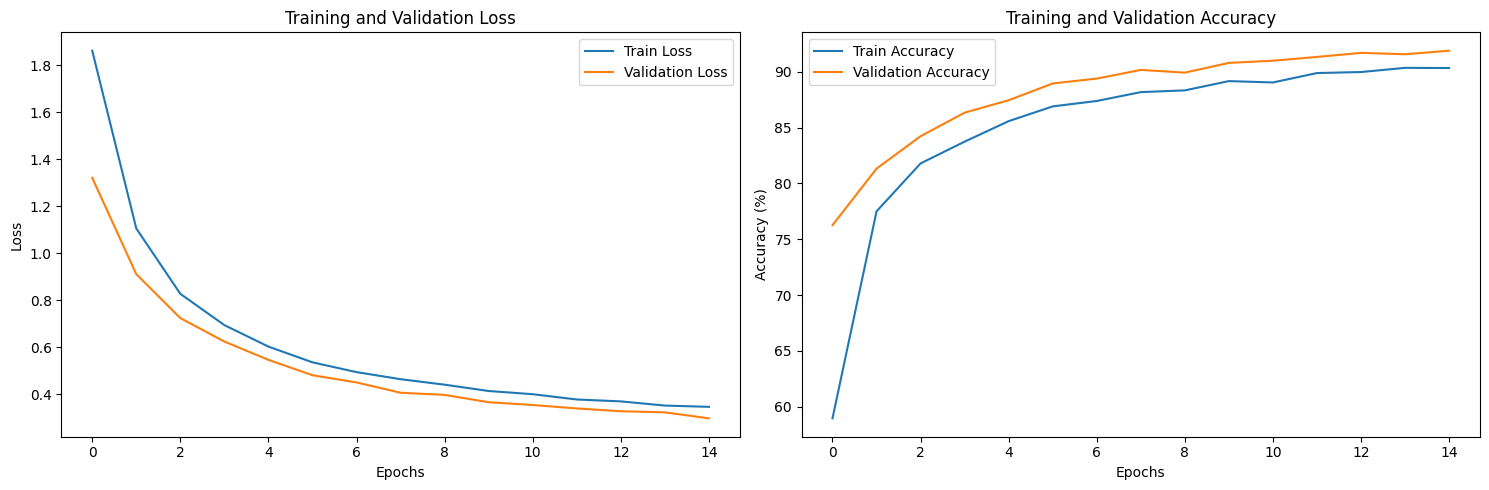


Final Evaluation:


Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/1021250105.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 129/129 [00:17<00:00,  7.39it/s]

Accuracy: 0.9188

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.97      0.98       188
                     Pepper__bell___healthy       0.97      0.99      0.98       297
                      Potato___Early_blight       0.96      0.98      0.97       182
                       Potato___Late_blight       0.94      0.97      0.96       203
                           Potato___healthy       0.90      0.90      0.90        30
                      Tomato_Bacterial_spot       0.92      0.95      0.93       463
                        Tomato_Early_blight       0.78      0.80      0.79       210
                         Tomato_Late_blight       0.89      0.87      0.88       378
                           Tomato_Leaf_Mold       0.90      0.91      0.90       200
                  Tomato_Septoria_leaf_spot       0.96      0.80      0.87       340
Tomato_Spider_mites_Two

In [23]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Installation de timm si nécessaire
    try:
        import timm
    except ImportError:
        print("Installation de timm...")
        import subprocess
        subprocess.run(["pip", "install", "timm"])
        import timm
    
    # Préparation des données
    data_path = "/kaggle/input/plantdisease/PlantVillage"
    train_loader, val_loader, class_names = prepare_data(data_path)
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'efficientnet_b0'  # Changer entre 'efficientnet_b0' ou 'vit_base_patch16_224'
    freeze_backbone = True  # Geler les poids pré-entraînés
    
    # Création du modèle pré-entraîné
    model = create_pretrained_model(model_arch, len(class_names))
    
    # Résumé avant la parallélisation
    try:
        print_model_summary(model.to(device))
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device, freeze_backbone=freeze_backbone)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()

Using device: cuda
GPU(s) disponibles: 2
Dataset trouvé à: /kaggle/input/plantdisease/PlantVillage
Train samples: 16509
Validation samples: 4128
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']... (15 au total)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipykernel_36/434000615.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

Training:   0%|          | 0/516 [00:00<?, ?it/s]/tmp/ipykernel_36/434000615.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/434000615.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 129/129 [00:10<00:00, 12.81it/s, Loss=0.6391, Acc=85.54%]


Meilleur modèle sauvegardé avec précision: 85.54%
Train Loss: 1.2016, Train Acc: 68.53%
Val Loss: 0.6341, Val Acc: 85.54%
Best Val Acc: 85.54%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:09<00:00, 12.94it/s, Loss=0.4071, Acc=90.96%]


Meilleur modèle sauvegardé avec précision: 90.96%
Train Loss: 0.5236, Train Acc: 87.81%
Val Loss: 0.4039, Val Acc: 90.96%
Best Val Acc: 90.96%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.80it/s, Loss=0.3083, Acc=93.10%]


Meilleur modèle sauvegardé avec précision: 93.10%
Train Loss: 0.3763, Train Acc: 91.10%
Val Loss: 0.3059, Val Acc: 93.10%
Best Val Acc: 93.10%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.48it/s, Loss=0.2551, Acc=94.45%]


Meilleur modèle sauvegardé avec précision: 94.45%
Train Loss: 0.2988, Train Acc: 92.74%
Val Loss: 0.2531, Val Acc: 94.45%
Best Val Acc: 94.45%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.21it/s, Loss=0.2132, Acc=95.32%]


Meilleur modèle sauvegardé avec précision: 95.32%
Train Loss: 0.2498, Train Acc: 94.12%
Val Loss: 0.2115, Val Acc: 95.32%
Best Val Acc: 95.32%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.32it/s, Loss=0.1876, Acc=95.54%]


Meilleur modèle sauvegardé avec précision: 95.54%
Train Loss: 0.2181, Train Acc: 94.91%
Val Loss: 0.1861, Val Acc: 95.54%
Best Val Acc: 95.54%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 11.76it/s, Loss=0.1678, Acc=96.32%]


Meilleur modèle sauvegardé avec précision: 96.32%
Train Loss: 0.1927, Train Acc: 95.29%
Val Loss: 0.1665, Val Acc: 96.32%
Best Val Acc: 96.32%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 11.97it/s, Loss=0.1501, Acc=96.56%]


Meilleur modèle sauvegardé avec précision: 96.56%
Train Loss: 0.1729, Train Acc: 95.95%
Val Loss: 0.1490, Val Acc: 96.56%
Best Val Acc: 96.56%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 11.82it/s, Loss=0.1367, Acc=96.95%]


Meilleur modèle sauvegardé avec précision: 96.95%
Train Loss: 0.1590, Train Acc: 96.32%
Val Loss: 0.1356, Val Acc: 96.95%
Best Val Acc: 96.95%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.19it/s, Loss=0.1240, Acc=97.46%]


Meilleur modèle sauvegardé avec précision: 97.46%
Train Loss: 0.1467, Train Acc: 96.34%
Val Loss: 0.1231, Val Acc: 97.46%
Best Val Acc: 97.46%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.26it/s, Loss=0.1164, Acc=97.36%]


Train Loss: 0.1346, Train Acc: 96.69%
Val Loss: 0.1155, Val Acc: 97.36%
Best Val Acc: 97.46%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.60it/s, Loss=0.1072, Acc=97.53%]


Meilleur modèle sauvegardé avec précision: 97.53%
Train Loss: 0.1259, Train Acc: 96.90%
Val Loss: 0.1064, Val Acc: 97.53%
Best Val Acc: 97.53%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.40it/s, Loss=0.1005, Acc=97.87%]


Meilleur modèle sauvegardé avec précision: 97.87%
Train Loss: 0.1172, Train Acc: 97.25%
Val Loss: 0.0997, Val Acc: 97.87%
Best Val Acc: 97.87%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.56it/s, Loss=0.0979, Acc=97.92%]


Meilleur modèle sauvegardé avec précision: 97.92%
Train Loss: 0.1099, Train Acc: 97.51%
Val Loss: 0.0971, Val Acc: 97.92%
Best Val Acc: 97.92%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 129/129 [00:10<00:00, 12.48it/s, Loss=0.0901, Acc=98.06%]


Meilleur modèle sauvegardé avec précision: 98.06%
Train Loss: 0.1066, Train Acc: 97.39%
Val Loss: 0.0894, Val Acc: 98.06%
Best Val Acc: 98.06%


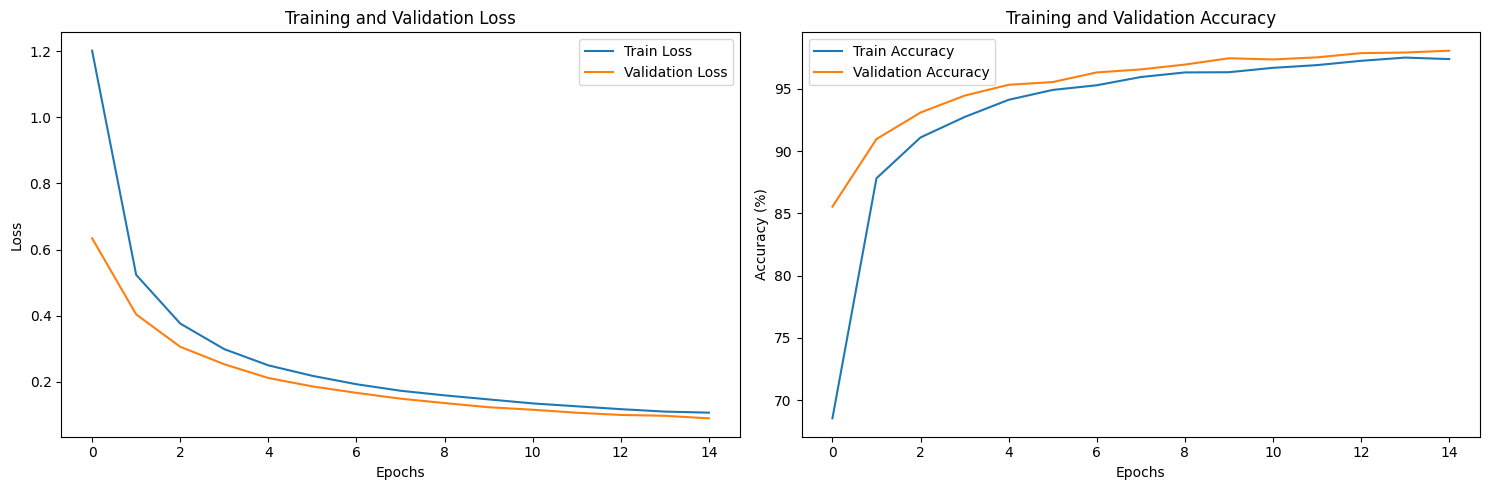


Final Evaluation:


Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]/tmp/ipykernel_36/1021250105.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluation: 100%|██████████| 129/129 [00:10<00:00, 11.84it/s]

Accuracy: 0.9806

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      1.00      1.00       198
                     Pepper__bell___healthy       1.00      1.00      1.00       301
                      Potato___Early_blight       0.99      1.00      0.99       208
                       Potato___Late_blight       0.99      0.99      0.99       198
                           Potato___healthy       1.00      1.00      1.00        29
                      Tomato_Bacterial_spot       0.97      0.99      0.98       413
                        Tomato_Early_blight       0.96      0.87      0.91       199
                         Tomato_Late_blight       0.96      0.99      0.98       357
                           Tomato_Leaf_Mold       0.99      0.98      0.99       193
                  Tomato_Septoria_leaf_spot       0.99      0.96      0.98       357
Tomato_Spider_mites_Two

In [24]:
# --- Fonction principale ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU(s) disponibles: {torch.cuda.device_count()}")
    
    # Installation de timm si nécessaire
    try:
        import timm
    except ImportError:
        print("Installation de timm...")
        import subprocess
        subprocess.run(["pip", "install", "timm"])
        import timm
    
    # Préparation des données
    data_path = "/kaggle/input/plantdisease/PlantVillage"
    train_loader, val_loader, class_names = prepare_data(data_path)
    
    if train_loader is None:
        print("Arrêt: données non disponibles")
        return
    
    print(f"Classes: {class_names[:10]}... ({len(class_names)} au total)")
    
    # Choix du modèle
    model_arch = 'vit_base_patch16_224'  # Changer entre 'efficientnet_b0' ou 'vit_base_patch16_224'
    freeze_backbone = True  # Geler les poids pré-entraînés
    
    # Création du modèle pré-entraîné
    model = create_pretrained_model(model_arch, len(class_names))
    
    # Résumé avant la parallélisation
    try:
        print_model_summary(model.to(device))
    except:
        print("Impossible d'afficher le résumé du modèle.")
    
    # Utilisation de plusieurs GPU
    if torch.cuda.device_count() > 1:
        print(f"Utilisation de {torch.cuda.device_count()} GPU(s) en parallèle")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Compilation du modèle (PyTorch 2.0+)
    try:
        model = torch.compile(model)
        print("Modèle compilé avec torch.compile")
    except Exception as e:
        print("torch.compile non disponible:", e)
    
    # Entraînement
    trainer = Trainer(model, train_loader, val_loader, len(class_names), device, freeze_backbone=freeze_backbone)
    trainer.train(num_epochs=15)
    
    # Graphiques
    trainer.plot_training_history()
    
    # Évaluation finale
    print("\nFinal Evaluation:")
    accuracy, cm, report = evaluate_model(model, val_loader, class_names, device)
    
    # Sauvegarde des résultats
    results = {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'train_accuracies': trainer.train_accuracies,
        'val_accuracies': trainer.val_accuracies,
        'final_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    torch.save(results, 'training_results.pth')
    print("✅ Entraînement terminé ! Meilleur modèle sauvegardé dans 'best_model.pth'")

if __name__ == "__main__":
    main()